## Perform standard imports

**[PyTorch](https://pytorch.org/docs/stable/index.html)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torch.utils.data import Subset      # it is used to split our data
from torchvision import datasets, transforms
from torchsummary import summary

from sklearn.model_selection import train_test_split # it is used to split our data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset
PyTorch makes the MNIST dataset available through <a href='https://pytorch.org/vision/stable/index.html'><tt><strong>torchvision</strong></tt></a>. The first time it's called, the dataset will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.


### Define transform
As part of the loading process, we can apply multiple transformations (*`reshape, convert to tensor, normalize, etc.`*) to the incoming data. For this exercise we only need to **convert images to tensors**.

**[transforms.Compose()](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html)**



In [ ]:
transform = transforms.Compose([transforms.ToTensor(),])

### Load the training set

**[torchvision.datasets.MNIST()](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html)**



In [ ]:
train_data = datasets.MNIST("MNIST",
                           download = True,
                           train = True,
                            transform = transform)

train_data

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting **train=False**. As before, torchvision will only download this once, and in the future will look for the local copy.

In [ ]:
test_data = datasets.MNIST("MNIST",
                           download = True,
                           train = False,
                            transform = transform)

test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### The first record from `train_data`

Calling the first record from <tt>train_data</tt> returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is a label.

In [ ]:
image, label = train_data[0]
print('Shape : ',image.shape,'\nLabel :',label)

Shape :  torch.Size([1, 28, 28]) 
Label : 5


### View the image
Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

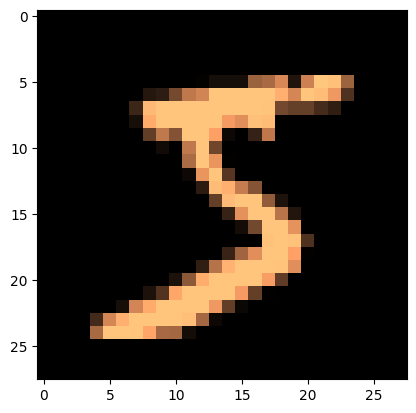

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)),
           cmap=plt.get_cmap("copper"));

## Batch loading with DataLoader

This section shows how to take advantage of PyTorch's <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a> tool.
This technique becomes very helpful with large datasets.

In the cell below, the first parameter is a PyTorch <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset'><em>Dataset</em></a> object (an object that supports data loading and sampling).<br>
The <tt><strong>batch_size</strong></tt> is the number of records to be processed at a time. If it's not evenly divisible into the dataset, then the final batch contains the remainder.<br>
Setting <tt><strong>shuffle</strong></tt> to True means that the dataset will be shuffled after each epoch.

<div class="alert alert-info"><strong>NOTE:</strong> DataLoader takes an optional <tt><strong>num_workers</strong></tt> parameter that sets up how many subprocesses to use for data loading. This behaves differently with different operating systems so we've omitted it here. See <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>the docs</a> for more information.</div>

In [ ]:
train_loader = DataLoader(train_data,
                          batch_size=64,
                          shuffle=True)

test_loader = DataLoader(test_data,
                         batch_size=64,
                         shuffle=True)

The batch tensors fed in by **DataLoader have a shape of** [64, 1, 28, 28]:

In [ ]:
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([64, 1, 28, 28])


## Flatten the data

We can **flatten** them using <tt>.view()</tt>

In [ ]:
images.view(64, -1).size()

torch.Size([64, 784])

We'll do this just before applying the model to our data.

# MNIST Code Along with ANN
Before we start working with Convolutional Neural Networks (CNN), let's model the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a> using only linear layers.<br>
In this exercise we'll use the same logic laid out in the ANN notebook. We'll reshape the MNIST data from a 28x28 image to a flattened 1x784 vector to mimic a single row of 784 features.

## Define the model
For this exercise we'll use fully connected layers to develop a <a href='https://en.wikipedia.org/wiki/Multilayer_perceptron'>multilayer perceptron</a>.<br>
Our **input size is 784** once we flatten the incoming 28x28 tensors.<br>
Our **output size represents the 10 possible digits**.<br>
We'll set our **hidden layers to [128, 64]** for now. Once you've completed the exercise feel free to come back and try different values.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=784, output_dim=10, layers=[128,64]):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], output_dim)

    def forward(self, X):
      X = F.relu(self.fc1(X))
      X = F.relu(self.fc2(X))
      X = self.fc3(X)
      return X

In [ ]:
model = MLP()
summary(model, input_size=(28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [ ]:
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## Define loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Train the model
This time we'll run the test data through the model during each epoch, so that we can compare loss & accuracy on the same plot.


In [ ]:
epochs = 3
train_loss = []
train_correct = []

for i in range(epochs):
  train_accuracy = 0
  N_train = 0
  for X_train, y_train in train_loader:
    N_train += X_train.shape[0]

    #train
    X_train = X_train.view(X_train.shape[0], -1) #784dim
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    #tune/update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #keep acc
    bath_correct = (y_pred.argmax(dim=-1) == y_train).sum()
    train_accuracy += bath_correct

  #print loss
  print(f"epoch: {i:2} loss: {loss.item():10.8f} accuracy:{100*train_accuracy/N_train:7.3f}% ")

  #update loss
  train_correct.append(100*train_accuracy.item()/N_train)

epoch:  0 loss: 0.10478137 accuracy: 97.835% 
epoch:  1 loss: 0.03278845 accuracy: 98.170% 
epoch:  2 loss: 0.01881175 accuracy: 98.493% 


## Test the model

In [ ]:
# Run the testing batches
with torch.no_grad():
  N_test = 0
  test_accuracy = 0
  for X_test, y_test in test_loader:
    N_test += X_test.shape[0]

    #Apply the model
    X_test = X_test.view(X_test.shape[0], -1)
    y_pred = model(X_test)

    #Tally the number of correct predictions
    test_accuracy += (y_pred.argmax(dim=-1) == y_test).sum()

#Testing accuracy
test_correct = 100*test_accuracy.item()/N_test
print(f"accuracy : {test_correct}")

accuracy : 97.73


# MNIST Code Along with CNN
Now that we've seen the results of an artificial neural network model on the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a>, let's work the same data with a <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>Convolutional Neural Network</a> (CNN).
Make sure to watch the theory lectures! You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

Note that in this exercise there is no need to flatten the MNIST data, as a CNN expects 2-dimensional data.

## Define a convolutional model
In the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28 images), hidden layers of 128 and 64 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows **CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC**.

Set up the convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a>


The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter.

In [ ]:
# Define layers
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)

In [ ]:
# prompt: Grab the first MNIST record

image, label = train_data[0]
print('Shape : ',image.shape,'\nLabel :',label)


Shape :  torch.Size([1, 28, 28]) 
Label : 5


In [ ]:
# Grab the first MNIST record
X_train, y_train = train_data[0]

In [ ]:
print(X_train.shape)

torch.Size([1, 28, 28])


In [ ]:
# prompt: Create a rank-4 tensor to be passed into the model

# Add a batch dimension.
X_train = X_train.unsqueeze(0)
print(X_train.shape)


torch.Size([1, 1, 1, 28, 28])


In [ ]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)


Activations can be applied to the convolutions in one line using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a> and pooling is done using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a>

torch.Size([1, 6, 26, 26])


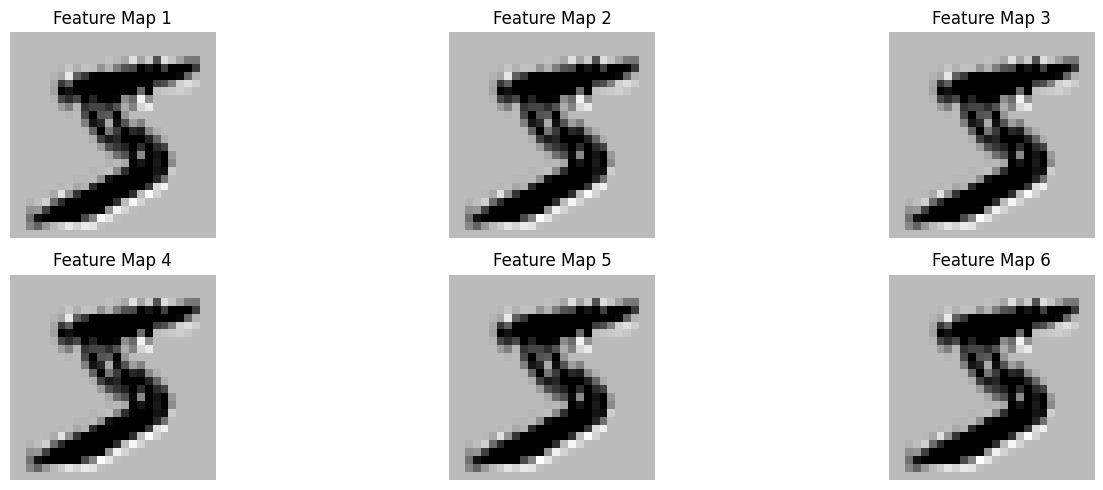

In [ ]:
# Perform the first convolution/activation
x = X_train.view(1,1,28,28)
x = F.relu(conv1(x))
print(x.shape)

num_feature_map = x.shape[1]
plt.figure(figsize=(15,5))
for i in range(num_feature_map):
  plt.subplot(2, num_feature_map//2, i+1)
  plt.imshow(x[0,1].detach().numpy(), cmap="gray")
  plt.axis("off")
  plt.title(f"Feature Map {i+1}")
plt.tight_layout()
plt.show()


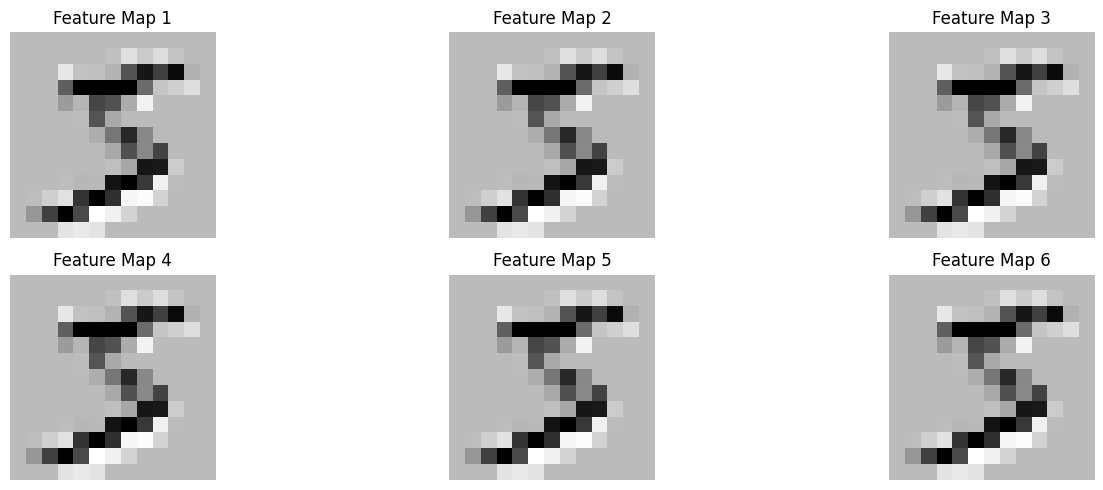

In [ ]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)

num_feature_map = x.shape[1]
plt.figure(figsize=(15,5))
for i in range(num_feature_map):
  plt.subplot(2, num_feature_map//2, i+1)
  plt.imshow(x[0,1].detach().numpy(), cmap="gray")
  plt.axis("off")
  plt.title(f"Feature Map {i+1}")
plt.tight_layout()
plt.show()

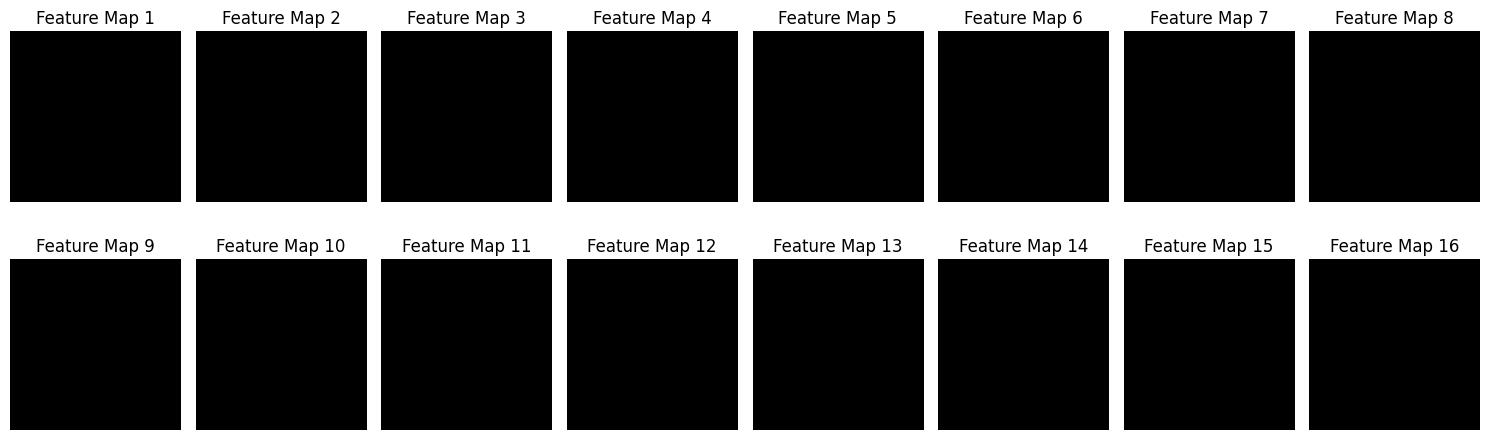

In [ ]:
# Perform the second convolution/activation
x = F.relu(conv2(x))

num_feature_map = x.shape[1]
plt.figure(figsize=(15,5))
for i in range(num_feature_map):
  plt.subplot(2, num_feature_map//2, i+1)
  plt.imshow(x[0,1].detach().numpy(), cmap="gray")
  plt.axis("off")
  plt.title(f"Feature Map {i+1}")
plt.tight_layout()
plt.show()

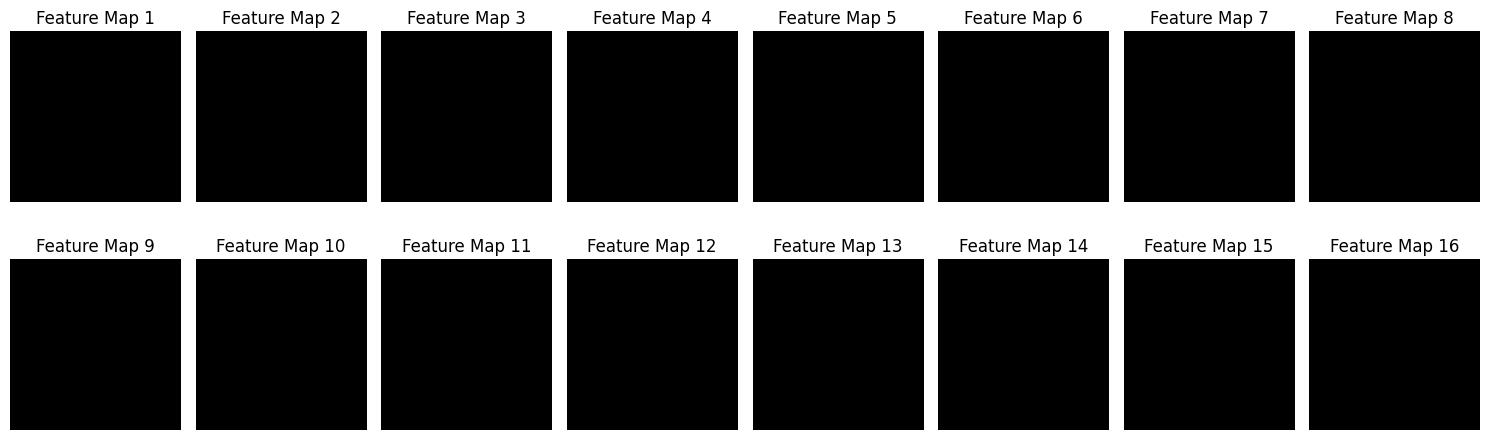

In [ ]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)

num_feature_map = x.shape[1]
plt.figure(figsize=(15,5))
for i in range(num_feature_map):
  plt.subplot(2, num_feature_map//2, i+1)
  plt.imshow(x[0,1].detach().numpy(), cmap="gray")
  plt.axis("off")
  plt.title(f"Feature Map {i+1}")
plt.tight_layout()
plt.show()

**Flatten** the data for the fully connected layers:



In [ ]:
# Flatten the data
x = x.view(-1,16*5*5)

<div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>

Now let's run the code.

In [ ]:
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)

batch_size = 1
input_tensor = torch.randn(batch_size, 1, 28, 28)
print("Input shape before conv1:", input_tensor.shape)

output = conv1(input_tensor)
print("Output shape after conv1:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)

output = conv2(output)
print("Output shape after conv2:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)

Input shape before conv1: torch.Size([1, 1, 28, 28])
Output shape after conv1: torch.Size([1, 6, 26, 26])
Output shape after max_pool2d: torch.Size([1, 6, 13, 13])
Output shape after conv2: torch.Size([1, 16, 11, 11])
Output shape after max_pool2d: torch.Size([1, 16, 5, 5])


## Construct CNN model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3)
    self.conv2 = nn.Conv2d(6,16,3)
    self.fc1 = nn.Linear(16*5*5, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 16*5*5) #flatten

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))

    X = self.fc3(X)
    return X


In [ ]:
modelCnn = CNN()
summary(modelCnn, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
            Conv2d-2           [-1, 16, 11, 11]             880
            Linear-3                  [-1, 128]          51,328
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 10]             650
Total params: 61,174
Trainable params: 61,174
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.23
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [ ]:
print(modelCnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## Define loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCnn.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [ ]:
epochs = 3
train_loss = []
train_correct = []

for i in range(epochs):
  train_accuracy = 0
  N_train = 0
  for X_train, y_train in train_loader:
    N_train += X_train.shape[0]

    #train
    y_pred = modelCnn(X_train)
    loss = criterion(y_pred, y_train)

    #tune/update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #keep acc
    bath_correct = (y_pred.argmax(dim=-1) == y_train).sum()
    train_accuracy += bath_correct

  #print loss
  print(f"epoch: {i:2} loss: {loss.item():10.8f} accuracy:{100*train_accuracy/N_train:7.3f}% ")

  #update loss
  train_correct.append(100*train_accuracy.item()/N_train)

epoch:  0 loss: 0.03944813 accuracy: 89.585% 
epoch:  1 loss: 0.02343314 accuracy: 96.837% 
epoch:  2 loss: 0.14255343 accuracy: 97.742% 


## Test the model

In [ ]:
# Run the testing batches
with torch.no_grad():
  N_test = 0
  test_accuracy = 0
  for X_test, y_test in test_loader:
    N_test += X_test.shape[0]

    #Apply the model
    y_pred = modelCnn(X_test)

    #Tally the number of correct predictions
    test_accuracy += (y_pred.argmax(dim=-1) == y_test).sum()

#Testing accuracy
test_correct = 100*test_accuracy.item()/N_test
print(f"accuracy : {test_correct}")

accuracy : 98.2


# Workshop on CIFAR-10 Dataset

The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), **CIFAR images are (3,32,32). There are 10 categories** an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

As with the previous code along, make sure to watch the theory lectures! You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

##6653380120-2 กัมแพงเพชร สิงห์ขรณ์ sec.1

## Load Dataset

In [ ]:
#Define transforms
transform = transforms.Compose([transforms.ToTensor(),])

#Load data
train_data = datasets.CIFAR10("CIFAR-10",
                            download = True,
                            train = True,
                            transform = transform)

test_data = datasets.CIFAR10("CIFAR-10",
                            download = True,
                            train = False,
                            transform = transform)

#batch loading with DataLoader
trainloader = DataLoader(train_data,
                          batch_size=64,
                          shuffle=True)

testloader = DataLoader(test_data,
                         batch_size=64,
                         shuffle=True)

#Define classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:18<00:00, 9157318.13it/s]


Extracting CIFAR-10/cifar-10-python.tar.gz to CIFAR-10
Files already downloaded and verified


## View a batch of images

Label: [    4     1     0     4     2     8     6     1     7     7]
Class:  deer car plane deer bird ship frog car horse horse


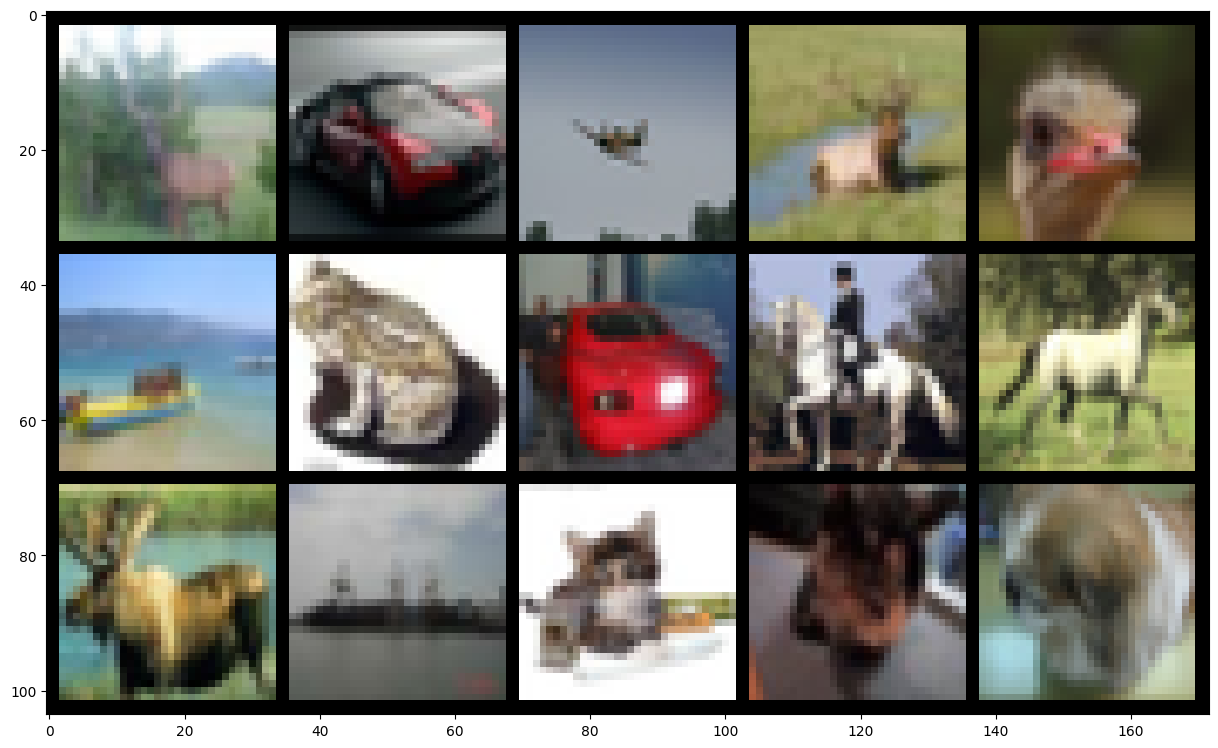

In [ ]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

for images,labels in trainloader:
    break

# Print the labels
print('Label:', labels[:10].numpy())
print('Class: ', *np.array([classes[i] for i in labels[:10]]))

# Print the images
im = make_grid(images[:15], nrow=5)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Tasks:
Create your CNN based on the given architecture:

1. The first layer comprises 32 of 3x3 filters

2. The first layer comprises 16 of 3x3 filters

3. For the module of the fully connected layers, it comprises 4 linear layers with size 128, 64, 32 and 10.

4. In each layer, the ReLU function is performed as the activation function.

5. The max pooling is used in every convolution layers.

## Construct CNN Model

In [ ]:
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)

batch_size = 1
input_tensor = torch.randn(batch_size, 3, 32, 32)
print("Input shape before conv1:", input_tensor.shape)

output = conv1(input_tensor)
print("Output shape after conv1:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)

output = conv2(output)
print("Output shape after conv2:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)

Input shape before conv1: torch.Size([1, 3, 32, 32])
Output shape after conv1: torch.Size([1, 32, 30, 30])
Output shape after max_pool2d: torch.Size([1, 32, 15, 15])
Output shape after conv2: torch.Size([1, 16, 13, 13])
Output shape after max_pool2d: torch.Size([1, 16, 6, 6])


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32,16,3)
    self.fc1 = nn.Linear(16*6*6, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 16*6*6)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = F.relu(self.fc3(X))
    X = self.fc4(X)
    return X

In [ ]:
modelCNN = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelCNN.to(device)

summary(modelCNN, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 16, 13, 13]           4,624
            Linear-3                  [-1, 128]          73,856
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 32]           2,080
            Linear-6                   [-1, 10]             330
Total params: 90,042
Trainable params: 90,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.24
Params size (MB): 0.34
Estimated Total Size (MB): 0.60
----------------------------------------------------------------


## Define loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.001)

## Train the model

In [ ]:
epochs = 50
train_loss = []
train_correct = []

for i in range(epochs):
  train_accuracy = 0
  N_train = 0
  for X_train, y_train in trainloader:
    N_train += X_train.shape[0]

    # Move X_train and y_train to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    #train
    y_pred = modelCNN(X_train)
    loss = criterion(y_pred, y_train)

    #tune/update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #keep acc
    bath_correct = (y_pred.argmax(dim=-1) == y_train).sum()
    train_accuracy += bath_correct

  #print loss
  print(f"epoch: {i:2} loss: {loss.item():10.8f} accuracy:{100*train_accuracy/N_train:7.3f}% ")

  #update loss
  train_correct.append(100*train_accuracy.item()/N_train)

epoch:  0 loss: 1.36519158 accuracy: 33.830% 
epoch:  1 loss: 1.32640529 accuracy: 48.126% 
epoch:  2 loss: 1.26765561 accuracy: 54.126% 
epoch:  3 loss: 1.15115619 accuracy: 58.128% 
epoch:  4 loss: 1.20397866 accuracy: 61.364% 
epoch:  5 loss: 1.07899952 accuracy: 63.668% 
epoch:  6 loss: 1.14907598 accuracy: 64.974% 
epoch:  7 loss: 0.70780265 accuracy: 66.722% 
epoch:  8 loss: 0.59602678 accuracy: 67.790% 
epoch:  9 loss: 1.16311347 accuracy: 69.040% 
epoch: 10 loss: 0.93183959 accuracy: 70.160% 
epoch: 11 loss: 0.98043513 accuracy: 71.158% 
epoch: 12 loss: 0.61534184 accuracy: 72.148% 
epoch: 13 loss: 0.40856478 accuracy: 72.810% 
epoch: 14 loss: 0.57847965 accuracy: 73.650% 
epoch: 15 loss: 0.87997603 accuracy: 74.510% 
epoch: 16 loss: 0.56260550 accuracy: 75.312% 
epoch: 17 loss: 0.34798336 accuracy: 76.090% 
epoch: 18 loss: 0.46261582 accuracy: 76.684% 
epoch: 19 loss: 0.59752548 accuracy: 77.236% 
epoch: 20 loss: 0.58532739 accuracy: 77.884% 
epoch: 21 loss: 0.74281871 accurac

## Test the model

In [ ]:
# Run the testing batches
with torch.no_grad():
  N_test = 0
  test_accuracy = 0
  for X_test, y_test in testloader:
    N_test += X_test.shape[0]

    # Move X_test and y_test to the device
    X_test = X_test.to(device) # Move X_test to the same device as the model
    y_test = y_test.to(device) # Move y_test to the same device as the model

    #Apply the model
    y_pred = modelCNN(X_test)

    #Tally the number of correct predictions
    test_accuracy += (y_pred.argmax(dim=-1) == y_test).sum()

#Testing accuracy
test_correct = 100*test_accuracy.item()/N_test
print(f"accuracy : {test_correct}")

accuracy : 64.47
